### Cartpole-v1 test

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

### Angle Reward function

In [2]:
def angleReward(obs, r):
    ang = np.abs(obs[2])
    return np.float32(r + 10*ang)

In [17]:
env = gym.make("CartPole-v1")
obs = env.reset()    
for i in range(1000):
    env.render()
    action = env.action_space.sample() # random action
    obs, reward, done, info = env.step(action)
    reward = angleReward(obs, reward)
#     print(i, action, obs)
    if done:
        break
        obs = env.reset()

In [18]:
env.close()

### agent with simple policy

In [11]:
def simpleAgent(env, policy, maxStep=1000):
    obs = env.reset()
    done = False
    ret = 0
    nStep = 0
    while not done:
        env.render()
        action = policy(obs)
        obs, r, done, info = env.step(action)
        r = angleReward(obs, r) 
        ret += r
        nStep += 1
        if nStep >= maxStep: break
    print (f"# of steps = {nStep}, Score = {ret}")
    return nStep, ret

### Random policy

In [13]:
def policy_random(obs):
    if np.random.random() < 0.5:
        return 0  # left
    else:
        return 1  # right
    
env = gym.make('CartPole-v1').unwrapped
simpleAgent(env, policy_random)

# of steps = 24, Score = 42.17370581626892


In [18]:
env.close()

### Heuristic policy using angle only

In [14]:
def policy_angle(obs):
    ang = obs[2]
    if ang < 0:
        return 0  # left
    else:
        return 1  # right
    
env = gym.make('CartPole-v1').unwrapped
simpleAgent(env, policy_angle)

# of steps = 45, Score = 82.23729848861694


In [18]:
env.close()

### Heuristic policy using angle and position

In [15]:
def policy_angle_pos(obs):
    pos = obs[0]
    ang = obs[2]
    if 10*ang - pos < 0:
        return 0  # left
    else:
        return 1  # right
    
env = gym.make('CartPole-v1').unwrapped
simpleAgent(env, policy_angle_pos)

# of steps = 40, Score = 79.64410078525543


In [18]:
env.close()

### Heuristic policy using angle, position, and velocity

In [16]:
def policy_angle_pos_vel(obs):
    pos = obs[0]
    vel = obs[1]
    ang = obs[2]
    if 10*ang + pos - vel < 0:
        return 0  # left
    else:
        return 1  # right
    
env = gym.make('CartPole-v1').unwrapped
simpleAgent(env, policy_angle_pos_vel)

# of steps = 402, Score = 566.6732250452042


In [18]:
env.close()

In [19]:
env = gym.make('CartPole-v1').unwrapped
simpleAgent(env, policy_random)
simpleAgent(env, policy_angle)
simpleAgent(env, policy_angle_pos)
simpleAgent(env, policy_angle_pos_vel)
env.close()

# of steps = 37, Score = 72.47981679439545
# of steps = 46, Score = 85.26617324352264
# of steps = 52, Score = 101.35597372055054
# of steps = 444, Score = 610.5356055498123


In [20]:
def policy_from_CEM(obs):
    # plain reward
    # w = np.array([-0.00178353, 0.3374739, 0.72456414, 0.45043665]) 
    # angle reward w/ maxStep = 500
    # w = np.array([0.06272953, 0.77593657, 1.61835616, 5.55401569]) 
    # angle reward w/ maxStep = 2000
    w = np.array([0.04187407, 1.66633927, 1.48482396, 4.08942878])
    
    z = np.dot(w, obs)
    if z < 0:
        return 0
    else:
        return 1
    
env = gym.make('CartPole-v1').unwrapped
simpleAgent(env, policy_from_CEM, maxStep=2000)
env.close()

# of steps = 1632, Score = 2631.7863233089447


In [ ]:
env.close()  # to close video window

In [3]:
class AgentBase:
    def __init__(self, env):
        self.env = env
        self.eps = 0.1
        self.test = False
        self.alpha = 0.01
        self.dimState = env.observation_space.shape[0]
        self.numAction = env.action_space.n
        self.gamma = 1
        self.lam = 0
        self.nEpisode = 0
        self.nStep = 0
        self.initQ = 100

    def getStateRep(self, obs):
        return obs

    def getQs(self, s):
        return self.Q[s]

    def getQa(self, s, a):
        return self.Q[s, a]

    def getVs(self, s, done=False):
        if done:
            return 0
        qs = self.getQs(s)
        return np.max(qs)

    def piGreedy(self, state):
        q = self.getQs(state)
        a = q.argmax()
        return a

    def getAction(self, state):  # eps-greedy policy
        if self.test or (np.random.random() > self.eps):
            a = self.piGreedy(state)
        else:
            a = np.random.choice(self.numAction)
        return a

    def saveModel(self):
        pass

    def loadModel(self):
        pass

    def episodeStart(self):
        self.nEpisode += 1
        self.alpha = 1/(self.nEpisode + 100)
        self.eps = 1/(self.nEpisode + 1)

    def runEpisode1(self, maxStep=1000, render=False, stepCB=None, episodeCB=None):
        self.episodeStart()
        obs = self.env.reset()
        s = self.getStateRep(obs)
        done = False
        ret = 0
        nStep = 0
        self.ap = None
        df = 1
        if episodeCB:
            S = [s]
            A = []
            R = []
        while not done:
            if render:
                self.env.render()
            if self.ap:
                a = self.ap  # SARSA
            else:
                a = self.getAction(s)
            obs, r, done, info = self.env.step(a)
            r = angleReward(obs, r)
            ret += df * r
            df *= self.gamma
            sp = self.getStateRep(obs)
            if episodeCB:
                A.append(a)
                R.append(r)
                S.append(sp)
            if stepCB:
                stepCB(s, a, r, sp, done)
            s = sp
            nStep += 1
            if nStep >= maxStep:  # 500 for v1
                break
        self.nStep = nStep
        if not done:
            Vs = self.getQs(s).min()
            ret += df * Vs
            print(f'maxStep reached at {self.nEpisode}, V[s]={Vs}, ret={ret}')

        if (self.test == False) and (ret > self.retMax):  # save before episodeCB
            self.retMax = ret
            print (f'Record at {self.nEpisode}, ret={ret}, nStep={nStep}')
            self.saveModel()
        if episodeCB:
            episodeCB(S, A, R, done)
        return ret

    def runTrain(self, nEpisode=1000, maxStep=1000, stepCB=None, episodeCB=None):
        self.test = False
        retHist = []
        self.retMax = 0
        self.nEpisode = 0
        for i in range(nEpisode):
            ret = self.runEpisode1(maxStep=maxStep, stepCB=stepCB, episodeCB=episodeCB)
            #             print(f"Training episode {i}, return = {ret} in {self.nStep} steps")
            retHist.append(ret)

        self.loadModel()
        plt.plot(retHist)
        plt.show()

    def runTest(self, nEpisode=1, maxStep=1000, fn=None):
        if fn:
            self.loadModel(fn)
        self.test = True
        retHist = []
        if nEpisode>5:
            render = False
        else:
            render = True
        for i in range(nEpisode):
            ret = self.runEpisode1(maxStep=maxStep, render=render)
            print(f"Test episode {i}, return = {ret} in {self.nStep} steps")
            retHist.append(ret)

        if nEpisode > 1:
            G = np.array(retHist)
            mean = np.mean(G)
            std = np.std(G)
            print (f'mean = {mean}, std = {std}')

In [4]:
class AgentLinVFA(AgentBase):
    def __init__(self, env):
        super().__init__(env)
        self.dimFeat = (self.dimState+5)*2+1
        self.w = np.zeros(self.dimFeat)
        self.lam = 0.7

    def getFeature(self, s, a):
        # quad = [s[0]*s[0], s[1]*s[1], s[2]*s[2], s[3]*s[3], s[0]*s[1], s[0]*s[2], s[0]*s[3], s[1]*s[2], s[1]*s[3], s[2]*s[3]]
        quad = [s[0]*s[0], s[2]*s[2], s[0]*s[1], s[0]*s[2], s[1]*s[2]]
        s = np.concatenate ((s, quad))
        x = np.concatenate(([1], s, (a-0.5)*s))
        return x

    def saveModel(self, fn=None):
        if fn is None:
            fn = 'W.VFA.npy'
        np.save(fn, self.w)

    def loadModel(self, fn=None):
        if fn is None:
            fn = 'W.VFA.npy'
        self.w = np.load(fn)

    def printParam(self):
        print(f"{self.nStep}/{self.nEpisode} , w :", self.w)

    def getQs(self, s):
        x0 = self.getFeature(s, 0)
        q0 = np.dot(self.w, x0)
        x1 = self.getFeature(s, 1)
        q1 = np.dot(self.w, x1)
        return np.array([q0, q1])

    def getQa(self, s, a):
        xa = self.getFeature(s, a)
        return np.dot(self.w, xa)

    def episodeStart(self):
        # super().episodeStart()
        self.nEpisode += 1
        self.eps = 1/(self.nEpisode + 1)
        self.alpha = 1/(self.nEpisode + 1)
        # self.eps = 0.1
        # self.alpha = 0.1
        self.et = np.zeros(self.dimFeat)

    def update(self, target, s, a):
        qa = self.getQa(s, a)
        delta = target - qa
        alpha_delta = delta * self.alpha
        gamlam = self.gamma * self.lam
        grad = self.getFeature(s, a)
        self.et = gamlam*self.et + grad
        self.w += alpha_delta*self.et
        # self.printParam()

    def stepQ(self, s, a, r, sp, done):
        maxq = self.getVs(sp, done)
        self.ap = None
        target = r + self.gamma * maxq
        self.update(target, s, a)

    def stepSARSA(self, s, a, r, sp, done):
        self.ap = self.getAction(sp)
        qp = self.getQa(sp, self.ap)
        target = r + self.gamma * qp
        self.update(target, s, a)

    def episodeMC(self, S, A, R, done):
        T = len(R)
        if done:
            G = 0
        else:
            G = self.getVs(S[-1])
        for t in range(T - 1, -1, -1):
            G = self.gamma * G + R[t]
            self.update(G, S[t], A[t])
        # self.printParam()
        

Record at 1, ret=24.881914973258972, nStep=15
Record at 2, ret=215.70493876934052, nStep=162
Record at 125, ret=217.0362913608551, nStep=142
Record at 126, ret=217.62455034255981, nStep=130
Record at 145, ret=225.93858134746552, nStep=139
Record at 151, ret=251.68633031845093, nStep=159
Record at 172, ret=291.50401389598846, nStep=183
Record at 258, ret=305.4108930826187, nStep=170
Record at 280, ret=339.4967613220215, nStep=194


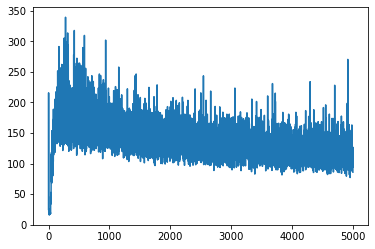

40/5000 , w : [  95.25292909  146.95714025   24.8876013   -12.36212269  229.50519078
  -92.22089346 -134.57830255  -91.34740559   43.26280749  -90.61891046
  519.47606575   56.58641625  136.59384934  663.13544452 -107.34234051
   -0.86044672 -105.27870966   -9.55764782 -165.58926326]
Test episode 0, return = 139.21032297611237 in 85 steps


In [9]:
env = gym.make('CartPole-v1').unwrapped
agent = AgentLinVFA(env)
agent.alpha = 0.01
agent.runTrain(episodeCB=agent.episodeMC, nEpisode=5000)
# agent.runTrain(stepCB=agent.stepTD, nEpisode=1000)
agent.printParam()
agent.runTest()
env.close()

In [16]:
env = gym.make('CartPole-v1').unwrapped
agent = AgentLinVFA(env)
agent.loadModel()
agent.runTest()
env.close()

Test episode 0, return = 176.76886022090912 in 117 steps


In [15]:
class AgentStateAgg(AgentLinVFA):
    def __init__(self, env):
        super().__init__(env)
        b = [[-1.0, -0.6, -0.3, -0.1, 0.1, 0.3, 0.6, 1.0],
             [-2, -1, -0.2, 0.2, 1, 2],
             [-0.17, -0.1, -0.05, -0.025, -0.005, 0.005, 0.025, 0.05, 0.1, 0.17],
             [-2, -1, -0.2, 0.2, 1, 2]]
        # b = [[-2, -1.2, -0.6, -0.1, 0.1, 0.6, 1.2, 2],  # 'Q.StAgg-Ret6514.npy'
        #      [-2, -1, -0.2, 0.2, 1, 2],
        #      [-0.17, -0.1, -0.05, -0.025, -0.005, 0.005, 0.025, 0.05, 0.1, 0.17],
        #      [-2, -1, -0.2, 0.2, 1, 2]]
        # b = [[-1.2, -0.3, 0.3, 1.2],
        #      [-1.5, -0.5, 0.5, 1.5],
        #      [-0.1, -0.05, 0.05, 0.1],
        #      [-2, -0.5, 0.5,  2]]
        self.breaks = b
        self.nBreaks = [len(b[0]),len(b[1]),len(b[2]),len(b[3])]
        self.dimV = [len(b[0])+1,len(b[1])+1,len(b[2])+1,len(b[3])+1]
        self.dimQ = self.dimV + [2]
        self.Q = np.full(self.dimQ, self.initQ, dtype=float)
        self.NV = np.zeros(self.dimV, dtype=int)
        self.NQ = np.zeros(self.dimQ, dtype=int)
        self.lam = 0.7
        # self.mins = np.zeros(4)
        # self.maxs = np.zeros(4)

    def printParam(self):
        # print(f"{self.nStep}/{self.nEpisode} , Q :", self.Q[1,1,1,1])
        pass

    def getIndexS(self, s):
        # self.mins = np.minimum(self.mins, s)
        # self.maxs = np.maximum(self.maxs, s)
        lidx = []
        for i in range(4):
            j = 0
            while j<self.nBreaks[i] and s[i] > self.breaks[i][j]:
                j += 1
            lidx.append(j)
        tidx = tuple(lidx)
        return tidx, lidx

    def getIndexSA(self, s, a):
        idxS, lidx = self.getIndexS(s)
        lidx.append(a)
        idxSA = tuple(lidx)
        return idxSA, idxS

    def getQs(self, s):
        idx,_ = self.getIndexS(s)
        return self.Q[idx]

    def getQa(self, s, a):
        idx,_ = self.getIndexSA(s,a)
        return self.Q[idx]

    def getAction(self, state):  # untried action first
        q = self.getQs(state)
        ga = q.argmax()
        if self.test: return ga
        if q[0] == self.initQ:
            return 0  # untried action
        elif q[1] == self.initQ:
            return 1
        elif np.random.random() > self.eps:
            return ga
        else:
            return np.random.choice(self.numAction)


    def update(self, target, s, a):
        idxSA,idxS = self.getIndexSA(s,a)
        # print(self.Q[idxS])
        self.NQ[idxSA] += 1
        self.NV[idxS] += 1
        self.alpha = 1/self.NQ[idxSA]
        self.Q[idxSA] += (target - self.Q[idxSA]) * self.alpha
        # print (self.Q[idxS])
        # self.printParam()

    def saveModel(self, fn=None):
        if fn is None:
            fn = 'Q.StAgg.npy'
        np.save(fn, self.Q)

    def loadModel(self, fn=None):
        if fn is None:
            fn = 'Q.StAgg.npy'
        self.Q = np.load(fn)

Record at 1, ret=18.408929228782654, nStep=10
Record at 2, ret=27.554908514022827, nStep=13
Record at 3, ret=47.99494481086731, nStep=31
Record at 6, ret=51.60437595844269, nStep=36
Record at 8, ret=143.0462063550949, nStep=75
Record at 28, ret=222.04238426685333, nStep=126
Record at 72, ret=231.06013584136963, nStep=101
Record at 83, ret=236.83221054077148, nStep=119
Record at 88, ret=292.5540623664856, nStep=151
Record at 191, ret=303.92513930797577, nStep=155
Record at 258, ret=329.8105808496475, nStep=168
Record at 452, ret=331.4083718061447, nStep=173
Record at 702, ret=334.5132429599762, nStep=192
Record at 887, ret=341.54221296310425, nStep=189
Record at 1120, ret=457.442547917366, nStep=230
Record at 1591, ret=467.1534731388092, nStep=236
Record at 1964, ret=527.8914705514908, nStep=268


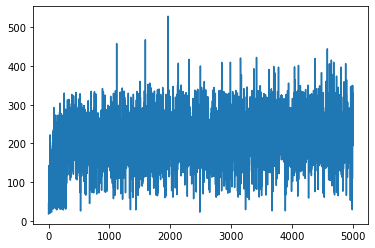

Test episode 0, return = 112.13729918003082 in 54 steps


In [18]:
env = gym.make('CartPole-v1').unwrapped
agent = AgentStateAgg(env)
# agent.runTrain(episodeCB=agent.episodeMC, nEpisode=10000, maxStep=2000)
# agent.runTrain(stepCB=agent.stepSARSA, nEpisode=10000)
agent.runTrain(stepCB=agent.stepQ, nEpisode=5000)
agent.runTest()
env.close()

In [17]:
env = gym.make('CartPole-v1').unwrapped
agent = AgentStateAgg(env)
agent.loadModel(fn)
agent.runTest(nEpisode=100)
env.close()

Test episode 0, return = 187.16479432582855 in 95 steps
